# Res-U-Net 
Mediante el método de transfer learning se hace uso de la red pre entrenada ResNet18.


In [1]:
import os 
import time
import math
import torch
import random
import torchvision
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, jaccard_score

## ResNet versión 2D

In [2]:
resnet=torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## ResNet versión 3D

In [3]:
resnet=torchvision.models.video.r3d_18()
resnet

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

# Adaptación de la primera capa para los datos de entrada propios

In [4]:
encoder = torchvision.models.video.r3d_18(weights="R3D_18_Weights.DEFAULT")           
encoder.stem = torch.nn.Sequential(
    nn.Conv3d(4, 64, kernel_size=7, stride=2, padding=3, bias=False),# Se debe cambiar la cantidad de canales de entrada a la cantidad dada por el one-hot encoding
    nn.BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True))
encoder


VideoResNet(
  (stem): Sequential(
    (0): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1)

# Implementación 

In [2]:
def conv3x3(in_size, out_size):
    return torch.nn.Sequential(
        nn.ReflectionPad3d(padding=(3 -1)//2),
        nn.Conv3d(in_size, out_size, 3, padding=0),
        nn.BatchNorm3d(out_size),
        nn.PReLU(),
        nn.Dropout())

class deconv(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose3d(in_size, out_size, 2, stride=2)
        self.conv1 = conv3x3(in_size, out_size)
        self.conv2 = conv3x3(out_size, out_size)
    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, in_size, out_size, final_size):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose3d(in_size, out_size, 2, stride=2)
        self.conv = conv3x3(in_size, out_size)
        self.final = torch.nn.Conv3d(out_size, final_size, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x = self.conv(x1) 
        x = self.final(x)
        return x

class ResUNet(torch.nn.Module):
    def __init__(self, in_ch=4, out_ch=1):
        super().__init__()
          
        self.encoder = torchvision.models.video.r3d_18(weights="R3D_18_Weights.DEFAULT")           
        self.encoder.stem = torch.nn.Sequential(
            nn.Conv3d(4, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True))

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, out_ch)

    def forward(self, x):
        x_in = x.clone().detach()
        #print(x_in.shape)
        x = self.encoder.stem(x)
        #print(x.shape)
        x1 = self.encoder.layer1(x)
        #print(x1.shape)
        x2 = self.encoder.layer2(x1)
        #print(x2.shape)
        x3 = self.encoder.layer3(x2)
        #print(x3.shape)
        x = self.encoder.layer4(x3)
        #print(x.shape)
        x = self.deconv1(x, x3)
        #print(x.shape)
        x = self.deconv2(x, x2)
        #print(x.shape)
        x = self.deconv3(x, x1)
        #print(x.shape)
        x = self.out(x, x_in)
        #print(x.shape)
        return x

## * Comprobar funcionamiento

In [6]:
model = ResUNet()
x = torch.randn((1, 4, 64, 64, 64))
output = model(x)
output.shape

torch.Size([1, 4, 64, 64, 64])
torch.Size([1, 64, 32, 32, 32])
torch.Size([1, 64, 32, 32, 32])
torch.Size([1, 128, 16, 16, 16])
torch.Size([1, 256, 8, 8, 8])
torch.Size([1, 512, 4, 4, 4])
torch.Size([1, 256, 8, 8, 8])
torch.Size([1, 128, 16, 16, 16])
torch.Size([1, 64, 32, 32, 32])
torch.Size([1, 1, 64, 64, 64])


torch.Size([1, 1, 64, 64, 64])

# Métricas

## Dice 

In [3]:
def dice(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1)
    pred=torch.round(pred, decimals=1)
    intersect = torch.sum((true == pred).int())
    union = math.prod(true.shape) + math.prod(pred.shape)
    return   torch.mean((2 * intersect) /(union+smooth))

## IoU

In [4]:
def iou(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1)
    pred=torch.round(pred, decimals=1)
    intersect = torch.sum((true == pred).int())
    union = math.prod(true.shape) + math.prod(pred.shape)-intersect
    return   torch.mean(intersect /(union+smooth))

# BCEDiceLoss


In [6]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, true, pred):
        true = true.view(-1)
        pred = pred.view(-1)
        # BCE loss
        bce_loss = nn.BCEWithLogitsLoss()(true, pred).double()
        # Dice Loss
        dice_coef = ((-(true-pred)**2+1).double().sum()) / (math.prod(true.shape))
        return bce_loss + (1 - dice_coef)

# Utils

## Seed

In [7]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Calculo del tiempo

In [8]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    
    return elapsed_mins, elapsed_secs

## Data loader

In [9]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
class Dataset (torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
       
    def __len__(self):
        assert len(self.x) == len(self.y), "La cantidad de volumenes no es equivalente a la cantidad de mascaras"
        return len(self.x)
    
    
    def __getitem__(self,ix):
        img = np.load(self.x[ix])
        mask = np.load(self.y[ix])
        img_oh = (np.arange(4) == img[...,None]).astype(np.float64)
        img_tensor= torch.tensor(img_oh).permute(3, 0, 1, 2)
        mask_e = mask/36.25
        mask_tensor = torch.tensor(mask_e).unsqueeze(0)
        
        return img_tensor, mask_tensor

In [11]:
def cargar_carpetas(carpeta, carpeta_estruc, carpeta_dosis ):
    direc = Path(carpeta +"/")
    estruc = [direc/carpeta_estruc/i for i in os.listdir(direc/carpeta_estruc)]
    dosis = [direc/carpeta_dosis/i for i in os.listdir(direc/carpeta_dosis)]
    estruc = sorted(estruc)
    dosis = sorted(dosis)
    print("Carpetas cargadas")
    if len(estruc) != len(dosis):
        print("La cantidad de volumenes no es equivalente a la cantidad de mascaras")
    print('La carpeta {} tiene {} volumenes y la carpeta {} tiene {} mascaras'.format(carpeta_estruc, len(estruc),carpeta_dosis, len(dosis)))
    
    return estruc, dosis

# * Entrenamiento de un solo volumen

In [16]:
estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')
dataset = Dataset(estruc[63:64], dosis[63:64])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

Carpetas cargadas
La carpeta Estructuras tiene 240 volumenes y la carpeta Dosis tiene 240 mascaras


In [17]:
x, y = next(iter(dataloader))

In [18]:
device = torch.device('cuda')
model = ResUNet()
model = model.to(device)

In [22]:
def fit(model, X, y, epochs=1, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    model.to(device)
    X = X.to(device=device, dtype=torch.float)
    y = y.to(device=device, dtype=torch.float)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        dices = dice(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.3f} dice {dices:.3f}")

In [1]:
fit(model, x, y, epochs=5000)

In [24]:
model.eval()
with torch.no_grad():
    output = model(x.to(device=device, dtype=torch.float))[0]

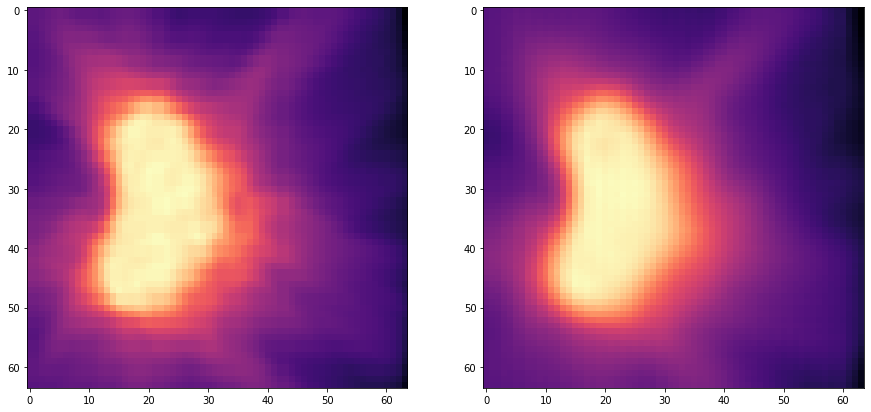

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(y[0,0,:,:,24],cmap="magma")
ax2.imshow(output[0,:,:,24].squeeze().cpu().numpy(),cmap="magma")
plt.show()

# * Resumen de arquitectura

In [26]:
summary(model, (4, 64, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 32, 32, 32]          87,808
       BatchNorm3d-2       [-1, 64, 32, 32, 32]             128
              ReLU-3       [-1, 64, 32, 32, 32]               0
      Conv3DSimple-4       [-1, 64, 32, 32, 32]         110,592
       BatchNorm3d-5       [-1, 64, 32, 32, 32]             128
              ReLU-6       [-1, 64, 32, 32, 32]               0
      Conv3DSimple-7       [-1, 64, 32, 32, 32]         110,592
       BatchNorm3d-8       [-1, 64, 32, 32, 32]             128
              ReLU-9       [-1, 64, 32, 32, 32]               0
       BasicBlock-10       [-1, 64, 32, 32, 32]               0
     Conv3DSimple-11       [-1, 64, 32, 32, 32]         110,592
      BatchNorm3d-12       [-1, 64, 32, 32, 32]             128
             ReLU-13       [-1, 64, 32, 32, 32]               0
     Conv3DSimple-14       [-1, 64, 32,

# Entrenamiento

In [12]:
estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')

Carpetas cargadas
La carpeta Estructuras tiene 240 volumenes y la carpeta Dosis tiene 240 mascaras


In [13]:
dataset = {
    "train" : Dataset(estruc[:180], dosis[:180]),
    "test" : Dataset(estruc[180:], dosis[180:])}

print(f'La cantidad de imágenes de entrenamiento son {len(dataset["train"])} y la cantidad de validación son {len(dataset["test"])}.')

La cantidad de imágenes de entrenamiento son 180 y la cantidad de validación son 60.


In [14]:
dataloader = {
    "train" : torch.utils.data.DataLoader(dataset["train"], batch_size=2, shuffle=True, pin_memory=True),
    "test" : torch.utils.data.DataLoader(dataset["test"], batch_size=2, pin_memory=True) }

imges, maskes = next(iter(dataloader["train"]))
imges.shape, maskes.shape

(torch.Size([2, 4, 64, 64, 64]), torch.Size([2, 1, 64, 64, 64]))

In [15]:
def train(model, dataloader, hist, met, optimizer, loss_fn, device):
    epoch_loss = 0.0
    bar = tqdm(dataloader['train'])
    train_loss= []
    model.train()
    for imges, maskes in bar:
        imges, maskes = imges.to(device, dtype=torch.float), maskes.to(device, dtype=torch.float)
        optimizer.zero_grad()
        y_pred = model(imges)
        loss = loss_fn(y_pred, maskes)
        loss.backward() 
        optimizer.step() 
        ious = iou(y_pred, maskes)
        dices = dice(y_pred, maskes)
        train_loss.append(loss.item())
        epoch_loss += loss.item()
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {ious:.3f} dice {dices:.3f}")
    hist['loss'].append(np.mean(train_loss))
    met["IoU"].append(np.mean(ious.cpu().numpy()*1))
    met["Dice"].append(np.mean(dices.cpu().numpy()*1))
    epoch_loss = epoch_loss/len(bar)
    
    return epoch_loss, hist, met

In [16]:
def evaluate(model, dataloader, hist, met, loss_fn, device):
    epoch_loss = 0.0
    bar = tqdm(dataloader['test'])
    test_loss = []
    model.eval()
    with torch.no_grad():
        for imges, maskes in bar:
            imges, maskes = imges.to(device,dtype=torch.float), maskes.to(device, dtype=torch.float)
            y_pred = model(imges)
            loss = loss_fn(y_pred, maskes)
            epoch_loss += loss.item()
            test_loss.append(loss.item())
            ious = iou(y_pred, maskes)
            dices = dice(y_pred, maskes)
            bar.set_description(f"test_loss {np.mean(test_loss):.5f} iou {ious:.3f} dice {dices:.3f}")
        hist['test_loss'].append(np.mean(test_loss))
        met["IoU_test"].append(np.mean(ious.cpu().numpy()*1))
        met["Dice_test"].append(np.mean(dices.cpu().numpy()*1))
        epoch_loss = epoch_loss/len(bar)
    
    return epoch_loss, hist, met

In [17]:
device = torch.device('cuda')
model = ResUNet()
model = model.to(device)

In [18]:
def fit(epochs=10, loss_fn = torch.nn.MSELoss(), model=model):
    if __name__ == "__main__":

        seeding(42)
        create_dir("file")

        epochs = epochs
        lr = 1e-4
        checkpoint_path = "file/checkpoint.pth" # Para guardar el modelo 

        dataloaders = dataloader

        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr= 1e-8)
        loss_fn = loss_fn
        
        # Entrenamiento
        hist = {'loss': [], 'test_loss': []}
        met = {"IoU": [], "Dice": [], "IoU_test": [], "Dice_test": []}
        best_valid_loss = float("inf")
        start_time = time.time()

        for epoch in range(1, epochs+1):
            print(f"\nEpoch {epoch}/{epochs}")

            train_loss, hist, met = train(model, dataloaders, hist, met, optimizer, loss_fn, device)
            valid_loss, hist, met = evaluate(model, dataloaders, hist, met, loss_fn, device)
        # Guardar el modelo entrenado 
            if valid_loss < best_valid_loss:
                data_str = f"Valid loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}. Saving checkpoint: {checkpoint_path}"
                print(data_str)

                best_valid_loss = valid_loss
                torch.save(model.state_dict(), checkpoint_path)
        # Mostrar avance del entrenamiento    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        data_str = f' Entrenamiento de {epochs} epocas finalizado en {epoch_mins}m {epoch_secs}s\n'
        print()
        print(data_str)
        
        return hist, met

## * Entrenamiento de 10 épocas con torch.nn.MSELoss

In [18]:
hist, met = fit(epochs=10, loss_fn = torch.nn.MSELoss())


Epoch 1/10


test_loss 0.02700 iou 0.177 dice 0.300: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.28it/s]


Valid loss improved from inf to 0.0270. Saving checkpoint: file/checkpoint.pth

Epoch 2/10


test_loss 0.01812 iou 0.339 dice 0.507: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.41it/s]


Valid loss improved from 0.0270 to 0.0181. Saving checkpoint: file/checkpoint.pth

Epoch 3/10


test_loss 0.00802 iou 0.409 dice 0.581: 100%|███████████████████████████████████████████| 30/30 [00:58<00:00,  1.96s/it]


Valid loss improved from 0.0181 to 0.0080. Saving checkpoint: file/checkpoint.pth

Epoch 4/10


test_loss 0.00870 iou 0.213 dice 0.352: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.95it/s]



Epoch 5/10


test_loss 0.00719 iou 0.471 dice 0.641: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.69it/s]


Valid loss improved from 0.0080 to 0.0072. Saving checkpoint: file/checkpoint.pth

Epoch 6/10


test_loss 0.00494 iou 0.409 dice 0.580: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.87it/s]


Valid loss improved from 0.0072 to 0.0049. Saving checkpoint: file/checkpoint.pth

Epoch 7/10


test_loss 0.00438 iou 0.441 dice 0.612: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.73it/s]


Valid loss improved from 0.0049 to 0.0044. Saving checkpoint: file/checkpoint.pth

Epoch 8/10


test_loss 0.00565 iou 0.429 dice 0.601: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.69it/s]



Epoch 9/10


test_loss 0.00631 iou 0.427 dice 0.598: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.65it/s]



Epoch 10/10


test_loss 0.00466 iou 0.429 dice 0.601: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.00it/s]


 Entrenamiento de 10 epocas finalizado en 5m 31s



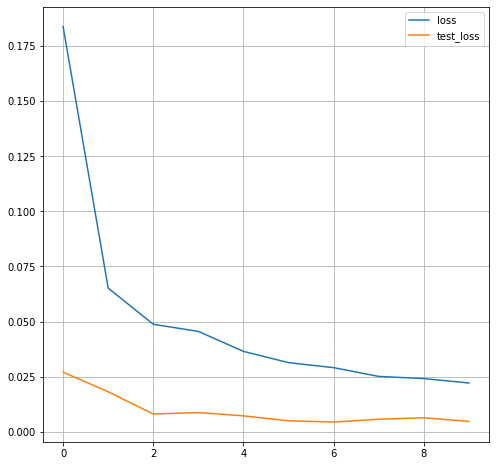

In [19]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

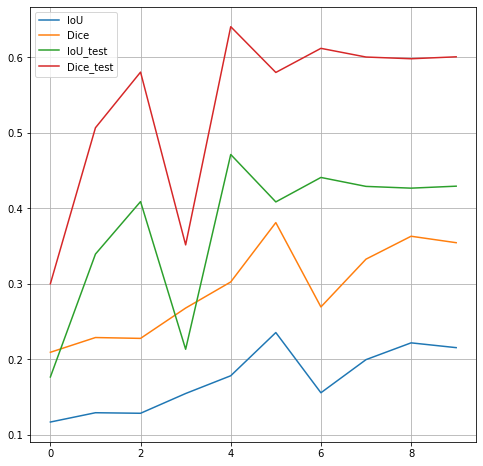

In [20]:
#10 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

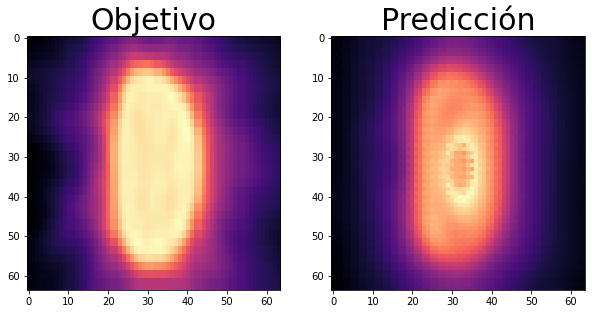

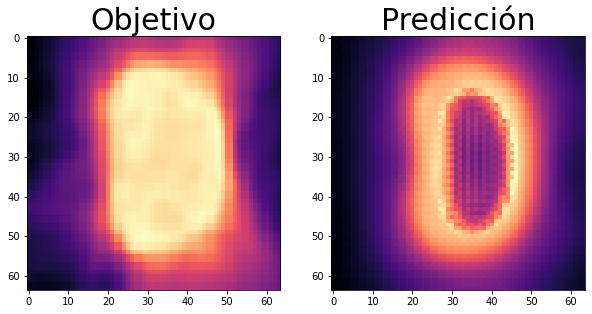

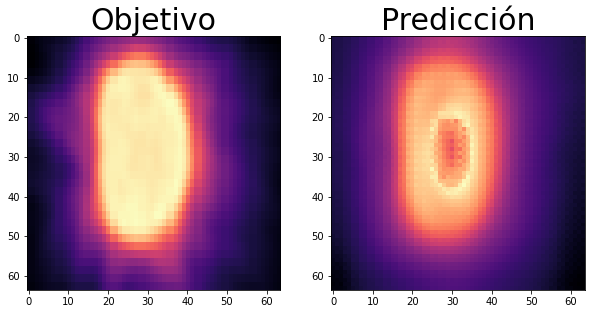

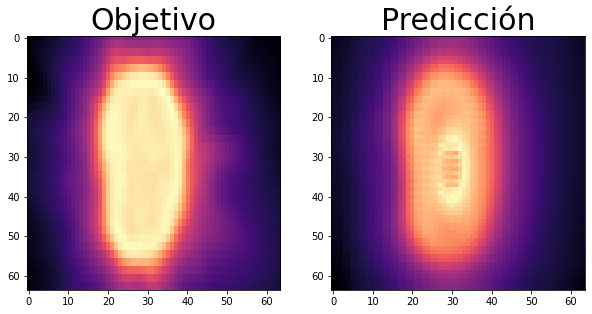

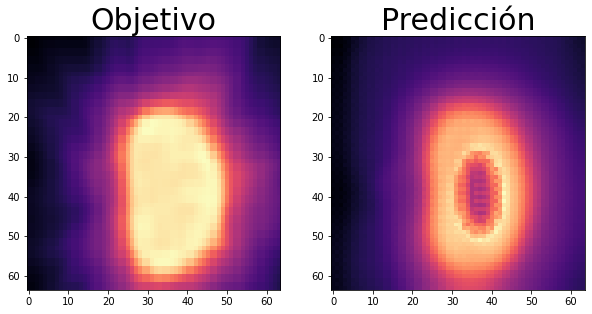

In [21]:
#10 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 100 épocas con torch.nn.MSELoss

In [22]:
hist, met = fit(epochs=100, loss_fn = torch.nn.MSELoss())


Epoch 1/100


test_loss 0.00523 iou 0.344 dice 0.512: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.47it/s]


Valid loss improved from inf to 0.0052. Saving checkpoint: file/checkpoint.pth

Epoch 2/100


test_loss 0.00486 iou 0.457 dice 0.627: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.25it/s]


Valid loss improved from 0.0052 to 0.0049. Saving checkpoint: file/checkpoint.pth

Epoch 3/100


test_loss 0.00428 iou 0.464 dice 0.634: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.13it/s]


Valid loss improved from 0.0049 to 0.0043. Saving checkpoint: file/checkpoint.pth

Epoch 4/100


test_loss 0.00436 iou 0.469 dice 0.638: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.52it/s]



Epoch 5/100


test_loss 0.00380 iou 0.475 dice 0.644: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.64it/s]


Valid loss improved from 0.0043 to 0.0038. Saving checkpoint: file/checkpoint.pth

Epoch 6/100


test_loss 0.00350 iou 0.509 dice 0.675: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.44it/s]


Valid loss improved from 0.0038 to 0.0035. Saving checkpoint: file/checkpoint.pth

Epoch 7/100


test_loss 0.00537 iou 0.455 dice 0.625: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.75it/s]



Epoch 8/100


test_loss 0.00251 iou 0.538 dice 0.699: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.63it/s]


Valid loss improved from 0.0035 to 0.0025. Saving checkpoint: file/checkpoint.pth

Epoch 9/100


test_loss 0.00523 iou 0.499 dice 0.666: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.19it/s]



Epoch 10/100


test_loss 0.00297 iou 0.514 dice 0.679: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]



Epoch 11/100


test_loss 0.00361 iou 0.446 dice 0.617: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.75it/s]



Epoch 12/100


test_loss 0.00269 iou 0.519 dice 0.684: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.74it/s]



Epoch 13/100


test_loss 0.00285 iou 0.494 dice 0.661: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.32it/s]



Epoch 14/100


test_loss 0.00234 iou 0.544 dice 0.704: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.21it/s]


Valid loss improved from 0.0025 to 0.0023. Saving checkpoint: file/checkpoint.pth

Epoch 15/100


test_loss 0.00304 iou 0.497 dice 0.664: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.60it/s]



Epoch 16/100


test_loss 0.00211 iou 0.558 dice 0.716: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.10it/s]


Valid loss improved from 0.0023 to 0.0021. Saving checkpoint: file/checkpoint.pth

Epoch 17/100


test_loss 0.00376 iou 0.519 dice 0.683: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.85it/s]



Epoch 18/100


test_loss 0.00254 iou 0.545 dice 0.705: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.08it/s]



Epoch 19/100


test_loss 0.00228 iou 0.540 dice 0.701: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.69it/s]



Epoch 20/100


test_loss 0.00220 iou 0.552 dice 0.711: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.44it/s]



Epoch 21/100


test_loss 0.00249 iou 0.558 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.93it/s]



Epoch 22/100


test_loss 0.00220 iou 0.532 dice 0.695: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.65it/s]



Epoch 23/100


test_loss 0.00345 iou 0.525 dice 0.689: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.95it/s]



Epoch 24/100


test_loss 0.00344 iou 0.456 dice 0.626: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.16it/s]



Epoch 25/100


test_loss 0.00332 iou 0.501 dice 0.667: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]



Epoch 26/100


test_loss 0.00379 iou 0.556 dice 0.714: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.46it/s]



Epoch 27/100


test_loss 0.00166 iou 0.571 dice 0.727: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.70it/s]


Valid loss improved from 0.0021 to 0.0017. Saving checkpoint: file/checkpoint.pth

Epoch 28/100


test_loss 0.00192 iou 0.566 dice 0.723: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.17it/s]



Epoch 29/100


test_loss 0.00205 iou 0.559 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.22it/s]



Epoch 30/100


test_loss 0.00188 iou 0.557 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.88it/s]



Epoch 31/100


test_loss 0.00213 iou 0.554 dice 0.713: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.78it/s]



Epoch 32/100


test_loss 0.00218 iou 0.556 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.52it/s]



Epoch 33/100


test_loss 0.00215 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.51it/s]



Epoch 34/100


test_loss 0.00274 iou 0.535 dice 0.697: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.46it/s]



Epoch 35/100


test_loss 0.00192 iou 0.567 dice 0.724: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.84it/s]



Epoch 36/100


test_loss 0.00187 iou 0.557 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.24it/s]



Epoch 37/100


test_loss 0.00236 iou 0.555 dice 0.714: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.23it/s]



Epoch 38/100


test_loss 0.00261 iou 0.526 dice 0.689: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]



Epoch 39/100


test_loss 0.00161 iou 0.548 dice 0.708: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]


Valid loss improved from 0.0017 to 0.0016. Saving checkpoint: file/checkpoint.pth

Epoch 40/100


test_loss 0.00228 iou 0.500 dice 0.667: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.84it/s]



Epoch 41/100


test_loss 0.00236 iou 0.539 dice 0.700: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.43it/s]



Epoch 42/100


test_loss 0.00286 iou 0.565 dice 0.722: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.18it/s]



Epoch 43/100


test_loss 0.00230 iou 0.556 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.63it/s]



Epoch 44/100


test_loss 0.00255 iou 0.554 dice 0.713: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.53it/s]



Epoch 45/100


test_loss 0.00167 iou 0.578 dice 0.733: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]



Epoch 46/100


test_loss 0.00186 iou 0.552 dice 0.711: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.69it/s]



Epoch 47/100


test_loss 0.00170 iou 0.559 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.88it/s]



Epoch 48/100


test_loss 0.00227 iou 0.585 dice 0.738: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.99it/s]



Epoch 49/100


test_loss 0.00186 iou 0.575 dice 0.730: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.77it/s]



Epoch 50/100


test_loss 0.00280 iou 0.531 dice 0.694: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.00it/s]



Epoch 51/100


test_loss 0.00182 iou 0.579 dice 0.734: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.07it/s]



Epoch 52/100


test_loss 0.00198 iou 0.582 dice 0.736: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.44it/s]



Epoch 53/100


test_loss 0.00182 iou 0.584 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.55it/s]



Epoch 54/100


test_loss 0.00317 iou 0.570 dice 0.726: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.11it/s]



Epoch 55/100


test_loss 0.00259 iou 0.544 dice 0.705: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]



Epoch 56/100


test_loss 0.00212 iou 0.564 dice 0.722: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.67it/s]



Epoch 57/100


test_loss 0.00180 iou 0.582 dice 0.735: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.55it/s]



Epoch 58/100


test_loss 0.00249 iou 0.577 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.33it/s]



Epoch 59/100


test_loss 0.00228 iou 0.546 dice 0.706: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.81it/s]



Epoch 60/100


test_loss 0.00244 iou 0.542 dice 0.703: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.17it/s]



Epoch 61/100


test_loss 0.00247 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.20it/s]



Epoch 62/100


test_loss 0.00188 iou 0.566 dice 0.723: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.57it/s]



Epoch 63/100


test_loss 0.00166 iou 0.564 dice 0.721: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.18it/s]



Epoch 64/100


test_loss 0.00182 iou 0.556 dice 0.714: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.90it/s]



Epoch 65/100


test_loss 0.00231 iou 0.527 dice 0.690: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.89it/s]



Epoch 66/100


test_loss 0.00175 iou 0.574 dice 0.729: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.99it/s]



Epoch 67/100


test_loss 0.00228 iou 0.529 dice 0.692: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.62it/s]



Epoch 68/100


test_loss 0.00219 iou 0.561 dice 0.718: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.59it/s]



Epoch 69/100


test_loss 0.00176 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.54it/s]



Epoch 70/100


test_loss 0.00199 iou 0.483 dice 0.652: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.68it/s]



Epoch 71/100


test_loss 0.00267 iou 0.527 dice 0.690: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]



Epoch 72/100


test_loss 0.00216 iou 0.564 dice 0.722: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.15it/s]



Epoch 73/100


test_loss 0.00173 iou 0.577 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.76it/s]



Epoch 74/100


test_loss 0.00164 iou 0.553 dice 0.712: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.68it/s]



Epoch 75/100


test_loss 0.00232 iou 0.519 dice 0.683: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]



Epoch 76/100


test_loss 0.00160 iou 0.552 dice 0.711: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.17it/s]


Valid loss improved from 0.0016 to 0.0016. Saving checkpoint: file/checkpoint.pth

Epoch 77/100


test_loss 0.00239 iou 0.505 dice 0.671: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.55it/s]



Epoch 78/100


test_loss 0.00175 iou 0.583 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.15it/s]



Epoch 79/100


test_loss 0.00188 iou 0.578 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.95it/s]



Epoch 80/100


test_loss 0.00207 iou 0.572 dice 0.728: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.94it/s]



Epoch 81/100


test_loss 0.00200 iou 0.525 dice 0.689: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.59it/s]



Epoch 82/100


test_loss 0.00208 iou 0.567 dice 0.724: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.68it/s]



Epoch 83/100


test_loss 0.00192 iou 0.548 dice 0.708: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.43it/s]



Epoch 84/100


test_loss 0.00179 iou 0.583 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.96it/s]



Epoch 85/100


test_loss 0.00224 iou 0.560 dice 0.718: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.79it/s]



Epoch 86/100


test_loss 0.00225 iou 0.537 dice 0.699: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.66it/s]



Epoch 87/100


test_loss 0.00209 iou 0.503 dice 0.669: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.43it/s]



Epoch 88/100


test_loss 0.00179 iou 0.541 dice 0.702: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.26it/s]



Epoch 89/100


test_loss 0.00248 iou 0.537 dice 0.698: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.67it/s]



Epoch 90/100


test_loss 0.00240 iou 0.541 dice 0.702: 100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 10.82it/s]



Epoch 91/100


test_loss 0.00229 iou 0.551 dice 0.711: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.59it/s]



Epoch 92/100


test_loss 0.00163 iou 0.593 dice 0.744: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.44it/s]



Epoch 93/100


test_loss 0.00254 iou 0.492 dice 0.659: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.32it/s]



Epoch 94/100


test_loss 0.00197 iou 0.556 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.00it/s]



Epoch 95/100


test_loss 0.00189 iou 0.528 dice 0.691: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.81it/s]



Epoch 96/100


test_loss 0.00249 iou 0.529 dice 0.692: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.82it/s]



Epoch 97/100


test_loss 0.00171 iou 0.572 dice 0.728: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.15it/s]



Epoch 98/100


test_loss 0.00183 iou 0.593 dice 0.745: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.04it/s]



Epoch 99/100


test_loss 0.00175 iou 0.556 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.66it/s]



Epoch 100/100


test_loss 0.00165 iou 0.594 dice 0.745: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  9.97it/s]


 Entrenamiento de 100 epocas finalizado en 41m 6s



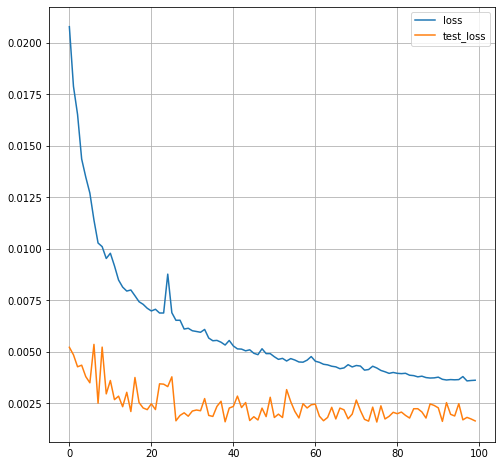

In [23]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

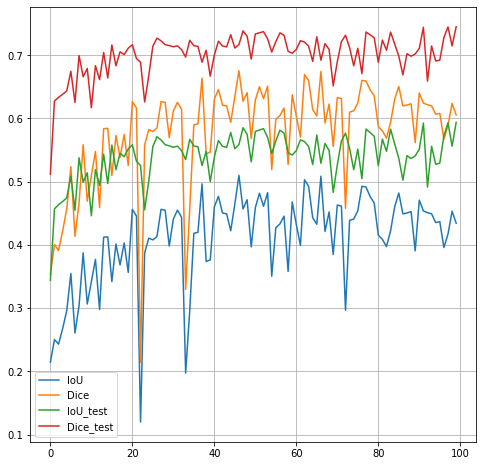

In [24]:
#100 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

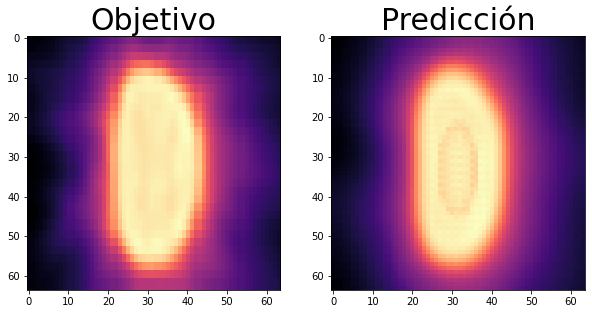

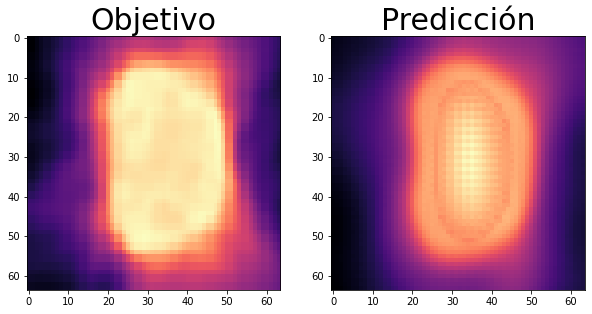

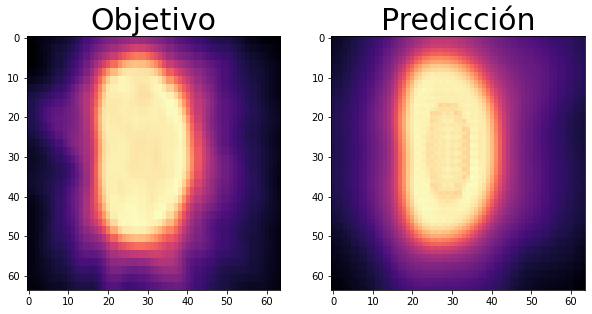

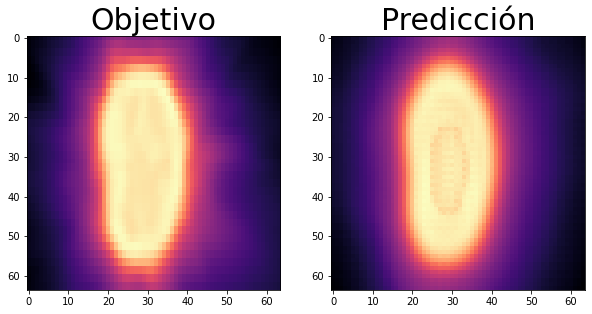

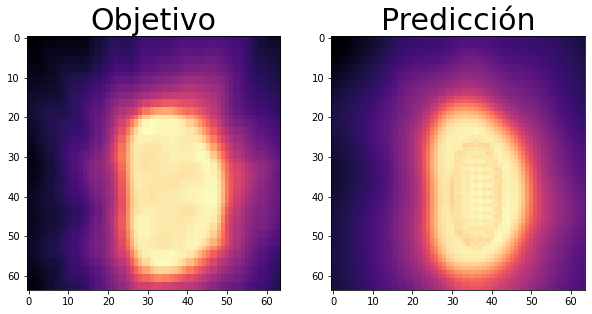

In [25]:
#100 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 10 épocas con BCEWithLogitsLoss

In [27]:
hist, met = fit(epochs=10, loss_fn = torch.nn.BCEWithLogitsLoss())


Epoch 1/10


test_loss 0.46974 iou 0.015 dice 0.030: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.69it/s]


Valid loss improved from inf to 0.4697. Saving checkpoint: file/checkpoint.pth

Epoch 2/10


test_loss 0.44362 iou 0.013 dice 0.027: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.09it/s]


Valid loss improved from 0.4697 to 0.4436. Saving checkpoint: file/checkpoint.pth

Epoch 3/10


test_loss 0.42203 iou 0.015 dice 0.029: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.69it/s]


Valid loss improved from 0.4436 to 0.4220. Saving checkpoint: file/checkpoint.pth

Epoch 4/10


test_loss 0.39767 iou 0.007 dice 0.014: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.36it/s]


Valid loss improved from 0.4220 to 0.3977. Saving checkpoint: file/checkpoint.pth

Epoch 5/10


test_loss 0.39808 iou 0.011 dice 0.022: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.99it/s]



Epoch 6/10


test_loss 0.38543 iou 0.008 dice 0.016: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Valid loss improved from 0.3977 to 0.3854. Saving checkpoint: file/checkpoint.pth

Epoch 7/10


test_loss 0.36939 iou 0.007 dice 0.014: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.68it/s]


Valid loss improved from 0.3854 to 0.3694. Saving checkpoint: file/checkpoint.pth

Epoch 8/10


test_loss 0.36085 iou 0.009 dice 0.018: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.40it/s]


Valid loss improved from 0.3694 to 0.3608. Saving checkpoint: file/checkpoint.pth

Epoch 9/10


test_loss 0.36018 iou 0.014 dice 0.027: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  5.00it/s]


Valid loss improved from 0.3608 to 0.3602. Saving checkpoint: file/checkpoint.pth

Epoch 10/10


test_loss 0.34349 iou 0.006 dice 0.012: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.15it/s]


Valid loss improved from 0.3602 to 0.3435. Saving checkpoint: file/checkpoint.pth

 Entrenamiento de 10 epocas finalizado en 6m 32s



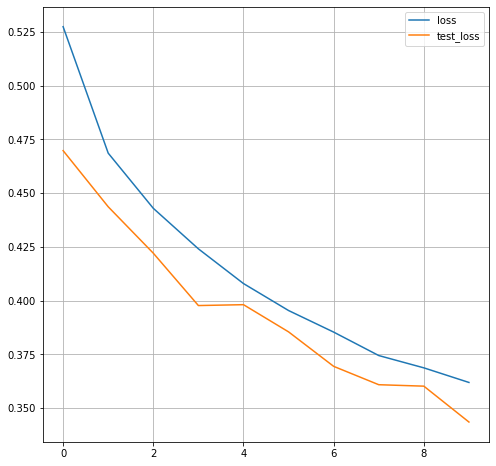

In [28]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

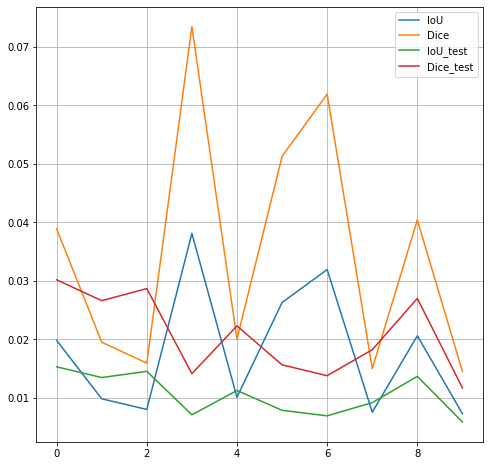

In [29]:
#10 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

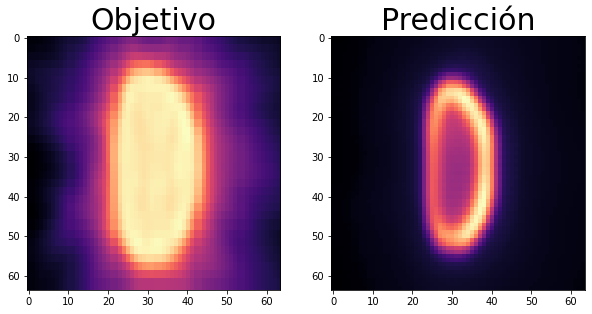

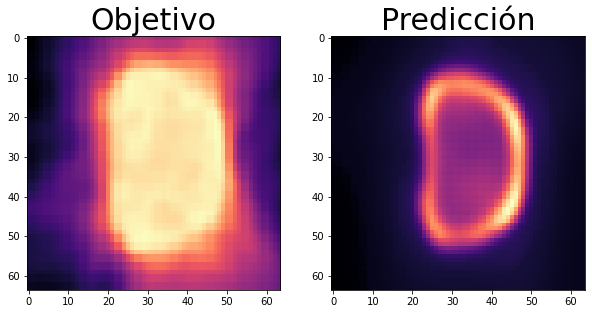

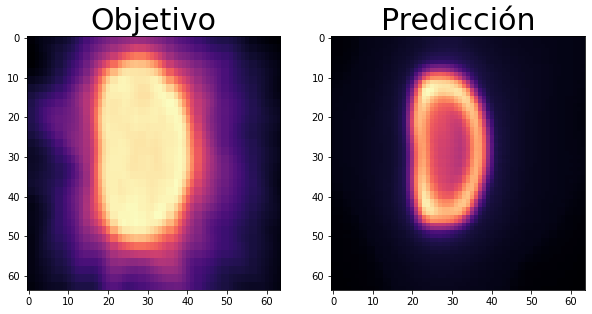

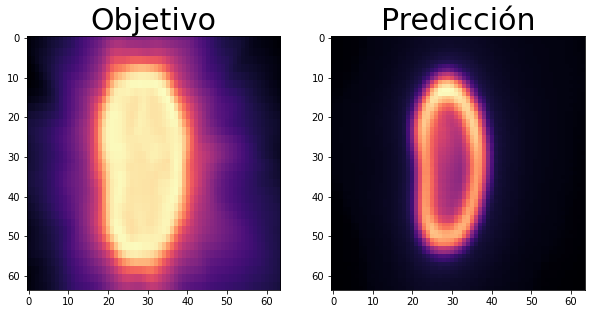

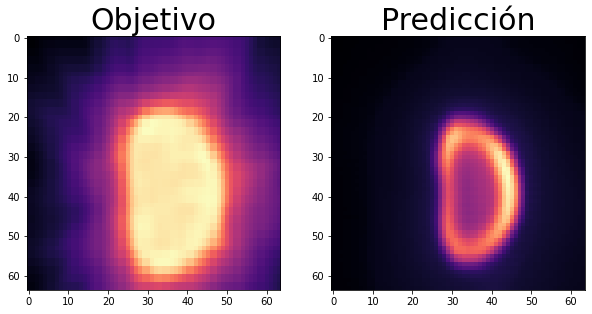

In [30]:
#10 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 10 épocas con torch.nn.L1Loss

In [22]:
hist, met = fit(epochs=10, loss_fn = torch.nn.L1Loss())


Epoch 1/10


test_loss 0.02930 iou 0.566 dice 0.723: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]


Valid loss improved from inf to 0.0293. Saving checkpoint: file/checkpoint.pth

Epoch 2/10


test_loss 0.02975 iou 0.547 dice 0.708: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.08it/s]



Epoch 3/10


test_loss 0.02620 iou 0.582 dice 0.736: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.65it/s]


Valid loss improved from 0.0293 to 0.0262. Saving checkpoint: file/checkpoint.pth

Epoch 4/10


test_loss 0.02600 iou 0.594 dice 0.745: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.70it/s]


Valid loss improved from 0.0262 to 0.0260. Saving checkpoint: file/checkpoint.pth

Epoch 5/10


test_loss 0.02630 iou 0.582 dice 0.736: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.15it/s]



Epoch 6/10


test_loss 0.03166 iou 0.561 dice 0.719: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.24it/s]



Epoch 7/10


test_loss 0.03156 iou 0.567 dice 0.724: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.24it/s]



Epoch 8/10


test_loss 0.02999 iou 0.556 dice 0.714: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]



Epoch 9/10


test_loss 0.03654 iou 0.535 dice 0.697: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.46it/s]



Epoch 10/10


test_loss 0.02774 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.09it/s]


 Entrenamiento de 10 epocas finalizado en 7m 37s



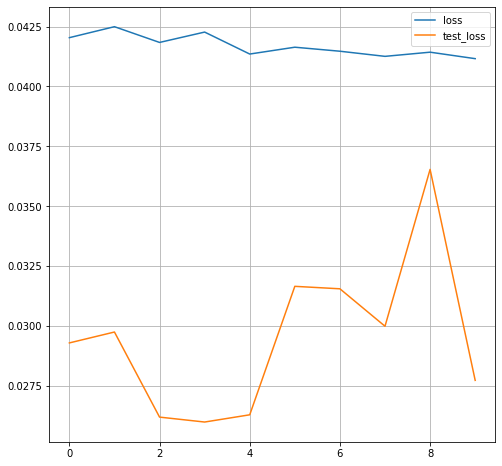

In [23]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

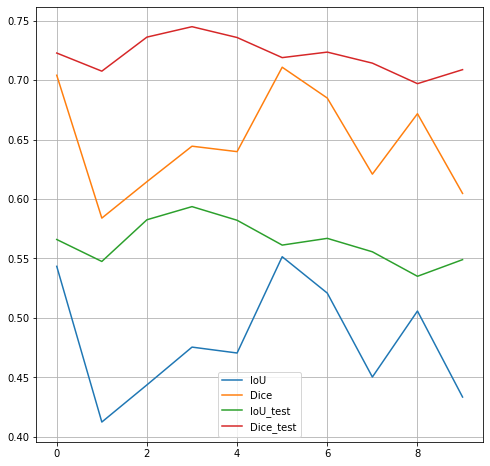

In [24]:
#10 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

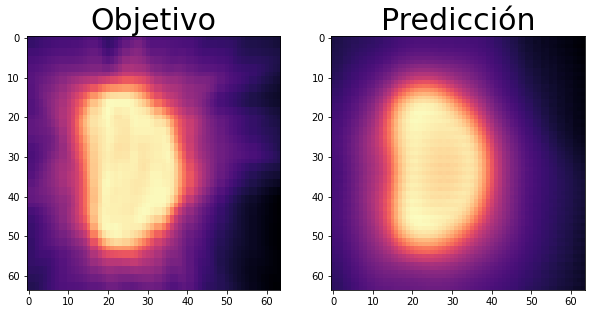

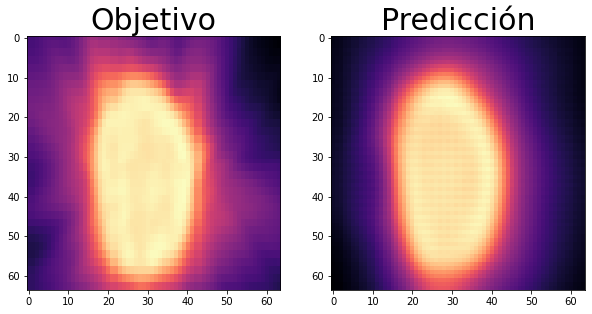

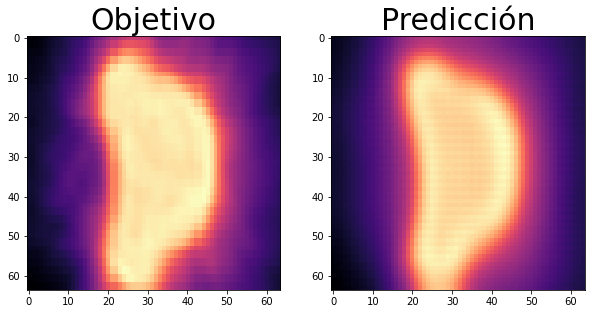

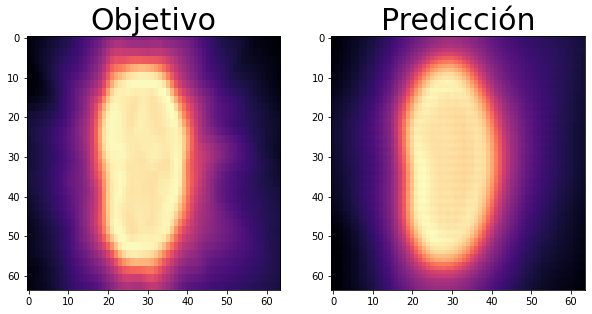

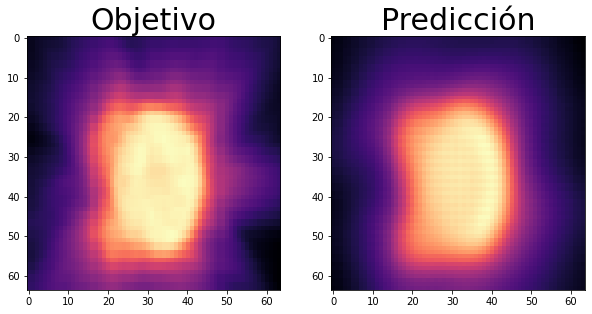

In [26]:
#10 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 100 épocas con torch.nn.L1Loss

In [19]:
hist, met = fit(epochs=100, loss_fn = torch.nn.L1Loss())


Epoch 1/100


test_loss 0.09650 iou 0.392 dice 0.563: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.83it/s]


Valid loss improved from inf to 0.0965. Saving checkpoint: file/checkpoint.pth

Epoch 2/100


test_loss 0.09169 iou 0.276 dice 0.433: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]


Valid loss improved from 0.0965 to 0.0917. Saving checkpoint: file/checkpoint.pth

Epoch 3/100


test_loss 0.04953 iou 0.443 dice 0.614: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Valid loss improved from 0.0917 to 0.0495. Saving checkpoint: file/checkpoint.pth

Epoch 4/100


test_loss 0.04939 iou 0.491 dice 0.659: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.51it/s]


Valid loss improved from 0.0495 to 0.0494. Saving checkpoint: file/checkpoint.pth

Epoch 5/100


test_loss 0.04109 iou 0.526 dice 0.690: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]


Valid loss improved from 0.0494 to 0.0411. Saving checkpoint: file/checkpoint.pth

Epoch 6/100


test_loss 0.04505 iou 0.495 dice 0.662: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]



Epoch 7/100


test_loss 0.04266 iou 0.512 dice 0.678: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]



Epoch 8/100


test_loss 0.03854 iou 0.483 dice 0.651: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.32it/s]


Valid loss improved from 0.0411 to 0.0385. Saving checkpoint: file/checkpoint.pth

Epoch 9/100


test_loss 0.04419 iou 0.461 dice 0.631: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]



Epoch 10/100


test_loss 0.03534 iou 0.534 dice 0.696: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Valid loss improved from 0.0385 to 0.0353. Saving checkpoint: file/checkpoint.pth

Epoch 11/100


test_loss 0.03810 iou 0.484 dice 0.653: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]



Epoch 12/100


test_loss 0.03303 iou 0.536 dice 0.698: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Valid loss improved from 0.0353 to 0.0330. Saving checkpoint: file/checkpoint.pth

Epoch 13/100


test_loss 0.03835 iou 0.532 dice 0.695: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]



Epoch 14/100


test_loss 0.03251 iou 0.543 dice 0.703: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]


Valid loss improved from 0.0330 to 0.0325. Saving checkpoint: file/checkpoint.pth

Epoch 15/100


test_loss 0.03449 iou 0.542 dice 0.703: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]



Epoch 16/100


test_loss 0.03490 iou 0.535 dice 0.697: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]



Epoch 17/100


test_loss 0.03188 iou 0.563 dice 0.720: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]


Valid loss improved from 0.0325 to 0.0319. Saving checkpoint: file/checkpoint.pth

Epoch 18/100


test_loss 0.04134 iou 0.512 dice 0.677: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]



Epoch 19/100


test_loss 0.03212 iou 0.561 dice 0.718: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]



Epoch 20/100


test_loss 0.03608 iou 0.512 dice 0.677: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]



Epoch 21/100


test_loss 0.04833 iou 0.465 dice 0.635: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]



Epoch 22/100


test_loss 0.03658 iou 0.528 dice 0.691: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]



Epoch 23/100


test_loss 0.03154 iou 0.545 dice 0.705: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]


Valid loss improved from 0.0319 to 0.0315. Saving checkpoint: file/checkpoint.pth

Epoch 24/100


test_loss 0.04356 iou 0.451 dice 0.622: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]



Epoch 25/100


test_loss 0.02973 iou 0.550 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Valid loss improved from 0.0315 to 0.0297. Saving checkpoint: file/checkpoint.pth

Epoch 26/100


test_loss 0.03364 iou 0.543 dice 0.704: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]



Epoch 27/100


test_loss 0.02775 iou 0.560 dice 0.718: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.77it/s]


Valid loss improved from 0.0297 to 0.0278. Saving checkpoint: file/checkpoint.pth

Epoch 28/100


test_loss 0.03091 iou 0.545 dice 0.706: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.97it/s]



Epoch 29/100


test_loss 0.02801 iou 0.545 dice 0.706: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]



Epoch 30/100


test_loss 0.03155 iou 0.531 dice 0.694: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]



Epoch 31/100


test_loss 0.03020 iou 0.566 dice 0.723: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]



Epoch 32/100


test_loss 0.02825 iou 0.585 dice 0.739: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]



Epoch 33/100


test_loss 0.02987 iou 0.547 dice 0.707: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]



Epoch 34/100


test_loss 0.03098 iou 0.509 dice 0.675: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Epoch 35/100


test_loss 0.02978 iou 0.554 dice 0.713: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]



Epoch 36/100


test_loss 0.03090 iou 0.521 dice 0.685: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]



Epoch 37/100


test_loss 0.03391 iou 0.506 dice 0.672: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.69it/s]



Epoch 38/100


test_loss 0.02789 iou 0.573 dice 0.729: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.86it/s]



Epoch 39/100


test_loss 0.02407 iou 0.576 dice 0.731: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]


Valid loss improved from 0.0278 to 0.0241. Saving checkpoint: file/checkpoint.pth

Epoch 40/100


test_loss 0.02698 iou 0.583 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]



Epoch 41/100


test_loss 0.02888 iou 0.556 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]



Epoch 42/100


test_loss 0.02878 iou 0.552 dice 0.711: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]



Epoch 43/100


test_loss 0.02939 iou 0.568 dice 0.725: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.86it/s]



Epoch 44/100


test_loss 0.03067 iou 0.536 dice 0.698: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]



Epoch 45/100


test_loss 0.02657 iou 0.575 dice 0.730: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]



Epoch 46/100


test_loss 0.02722 iou 0.555 dice 0.714: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]



Epoch 47/100


test_loss 0.02873 iou 0.528 dice 0.691: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]



Epoch 48/100


test_loss 0.02854 iou 0.571 dice 0.727: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]



Epoch 49/100


test_loss 0.02590 iou 0.573 dice 0.729: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]



Epoch 50/100


test_loss 0.02828 iou 0.558 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.09it/s]



Epoch 51/100


test_loss 0.02603 iou 0.569 dice 0.725: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]



Epoch 52/100


test_loss 0.02976 iou 0.563 dice 0.720: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]



Epoch 53/100


test_loss 0.02879 iou 0.557 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]



Epoch 54/100


test_loss 0.02783 iou 0.584 dice 0.738: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]



Epoch 55/100


test_loss 0.02871 iou 0.565 dice 0.722: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]



Epoch 56/100


test_loss 0.02605 iou 0.592 dice 0.743: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]



Epoch 57/100


test_loss 0.02711 iou 0.588 dice 0.741: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]



Epoch 58/100


test_loss 0.03311 iou 0.545 dice 0.705: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.59it/s]



Epoch 59/100


test_loss 0.03095 iou 0.544 dice 0.705: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]



Epoch 60/100


test_loss 0.03277 iou 0.535 dice 0.697: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.50it/s]



Epoch 61/100


test_loss 0.02611 iou 0.592 dice 0.743: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]



Epoch 62/100


test_loss 0.02930 iou 0.561 dice 0.719: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.58it/s]



Epoch 63/100


test_loss 0.02762 iou 0.560 dice 0.718: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]



Epoch 64/100


test_loss 0.02793 iou 0.562 dice 0.720: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.51it/s]



Epoch 65/100


test_loss 0.03464 iou 0.510 dice 0.675: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]



Epoch 66/100


test_loss 0.02487 iou 0.585 dice 0.738: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.34it/s]



Epoch 67/100


test_loss 0.03040 iou 0.550 dice 0.710: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]



Epoch 68/100


test_loss 0.03121 iou 0.552 dice 0.712: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]



Epoch 69/100


test_loss 0.02412 iou 0.595 dice 0.746: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]



Epoch 70/100


test_loss 0.02873 iou 0.559 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]



Epoch 71/100


test_loss 0.02507 iou 0.578 dice 0.733: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]



Epoch 72/100


test_loss 0.02817 iou 0.572 dice 0.728: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]



Epoch 73/100


test_loss 0.02457 iou 0.589 dice 0.741: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]



Epoch 74/100


test_loss 0.02755 iou 0.565 dice 0.722: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]



Epoch 75/100


test_loss 0.03268 iou 0.523 dice 0.687: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Epoch 76/100


test_loss 0.02480 iou 0.586 dice 0.739: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Epoch 77/100


test_loss 0.03314 iou 0.541 dice 0.702: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]



Epoch 78/100


test_loss 0.02834 iou 0.558 dice 0.716: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]



Epoch 79/100


test_loss 0.02652 iou 0.575 dice 0.730: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]



Epoch 80/100


test_loss 0.02658 iou 0.577 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]



Epoch 81/100


test_loss 0.02501 iou 0.584 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]



Epoch 82/100


test_loss 0.02903 iou 0.557 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]



Epoch 83/100


test_loss 0.03339 iou 0.520 dice 0.684: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]



Epoch 84/100


test_loss 0.02653 iou 0.574 dice 0.729: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]



Epoch 85/100


test_loss 0.02672 iou 0.585 dice 0.739: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]



Epoch 86/100


test_loss 0.02784 iou 0.571 dice 0.727: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]



Epoch 87/100


test_loss 0.02855 iou 0.561 dice 0.719: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]



Epoch 88/100


test_loss 0.02740 iou 0.566 dice 0.723: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Epoch 89/100


test_loss 0.03151 iou 0.543 dice 0.704: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.98it/s]



Epoch 90/100


test_loss 0.03050 iou 0.559 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]



Epoch 91/100


test_loss 0.02844 iou 0.578 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]



Epoch 92/100


test_loss 0.02664 iou 0.582 dice 0.735: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Epoch 93/100


test_loss 0.02722 iou 0.571 dice 0.727: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]



Epoch 94/100


test_loss 0.02367 iou 0.599 dice 0.749: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]


Valid loss improved from 0.0241 to 0.0237. Saving checkpoint: file/checkpoint.pth

Epoch 95/100


test_loss 0.02454 iou 0.592 dice 0.744: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]



Epoch 96/100


test_loss 0.02917 iou 0.562 dice 0.720: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]



Epoch 97/100


test_loss 0.03044 iou 0.545 dice 0.705: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]



Epoch 98/100


test_loss 0.02593 iou 0.596 dice 0.747: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]



Epoch 99/100


test_loss 0.02587 iou 0.580 dice 0.734: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]



Epoch 100/100


test_loss 0.02535 iou 0.587 dice 0.739: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


 Entrenamiento de 100 epocas finalizado en 58m 34s



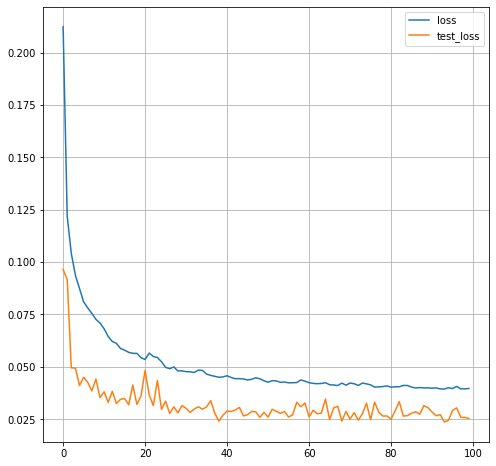

In [20]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

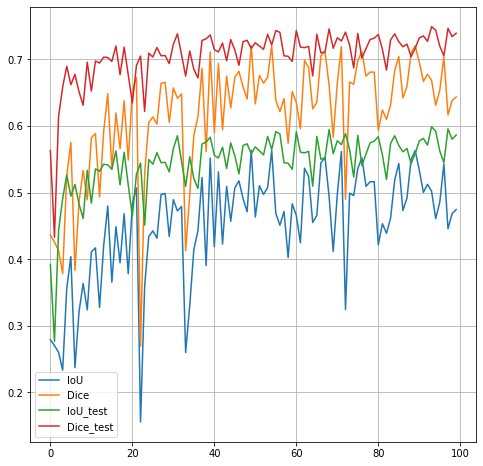

In [21]:
#100 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

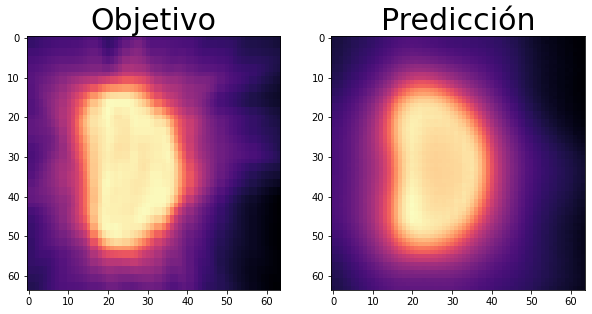

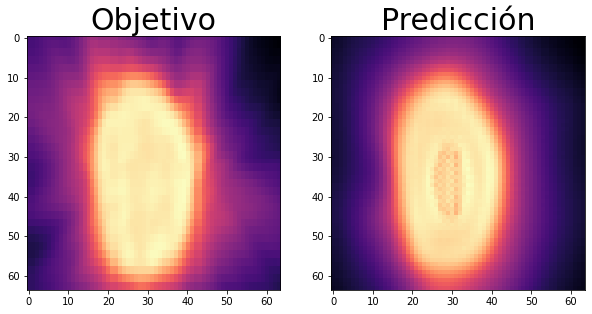

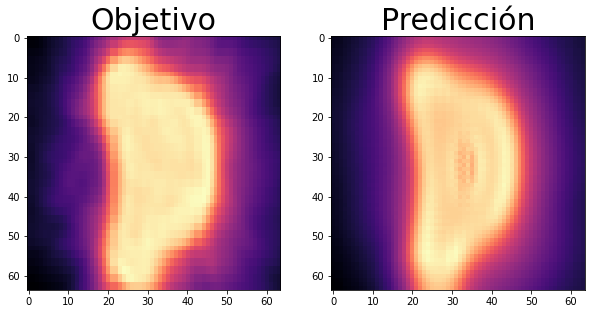

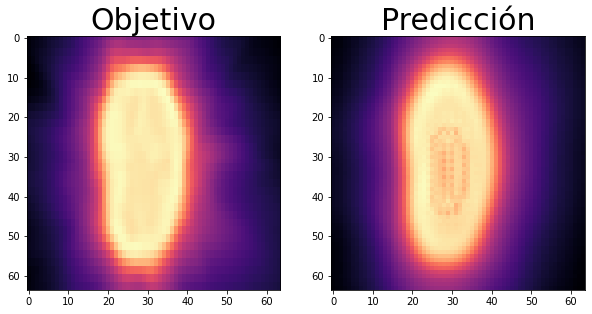

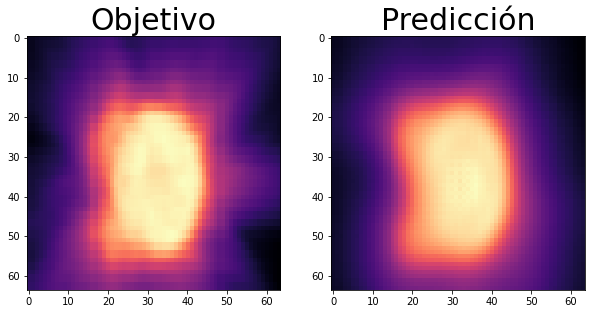

In [23]:
#100 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 10 épocas con BCEDiceLoss

In [34]:
hist, met = fit(epochs=10, loss_fn = BCEDiceLoss())


Epoch 1/10


test_loss 0.72353 iou 0.023 dice 0.046: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.27it/s]


Valid loss improved from inf to 0.7235. Saving checkpoint: file/checkpoint.pth

Epoch 2/10


test_loss 0.70850 iou 0.049 dice 0.094: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.58it/s]


Valid loss improved from 0.7235 to 0.7085. Saving checkpoint: file/checkpoint.pth

Epoch 3/10


test_loss 0.67857 iou 0.066 dice 0.124: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Valid loss improved from 0.7085 to 0.6786. Saving checkpoint: file/checkpoint.pth

Epoch 4/10


test_loss 0.68155 iou 0.067 dice 0.125: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.42it/s]



Epoch 5/10


test_loss 0.68296 iou 0.069 dice 0.130: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]



Epoch 6/10


test_loss 0.73346 iou 0.062 dice 0.117: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]



Epoch 7/10


test_loss 0.66016 iou 0.074 dice 0.138: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]


Valid loss improved from 0.6786 to 0.6602. Saving checkpoint: file/checkpoint.pth

Epoch 8/10


test_loss 0.66119 iou 0.077 dice 0.142: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]



Epoch 9/10


test_loss 0.66525 iou 0.076 dice 0.141: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]



Epoch 10/10


test_loss 0.67717 iou 0.074 dice 0.138: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]


 Entrenamiento de 10 epocas finalizado en 4m 7s



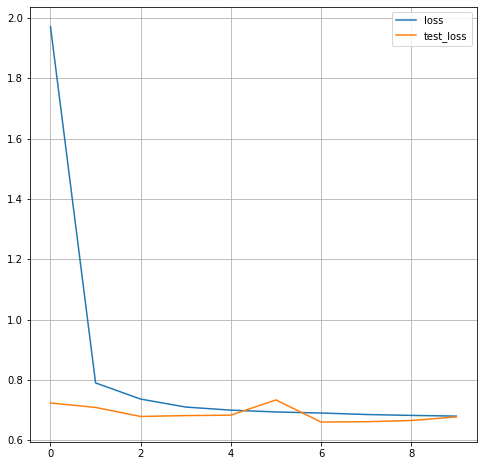

In [35]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

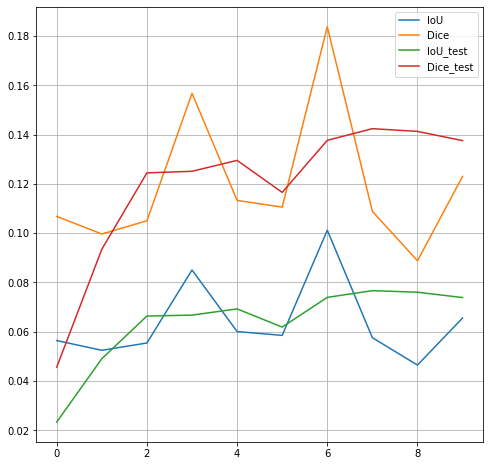

In [36]:
#10 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

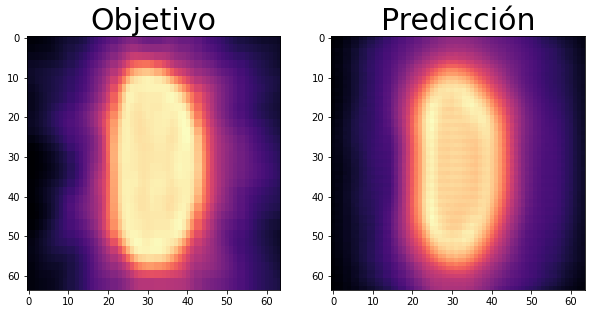

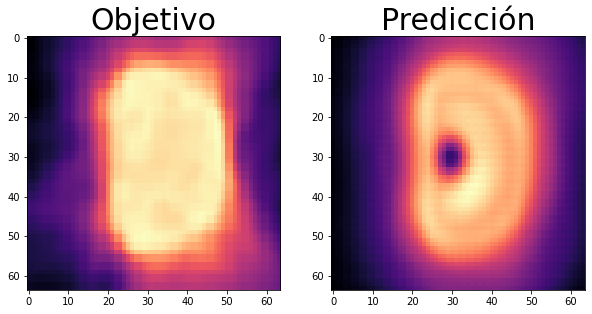

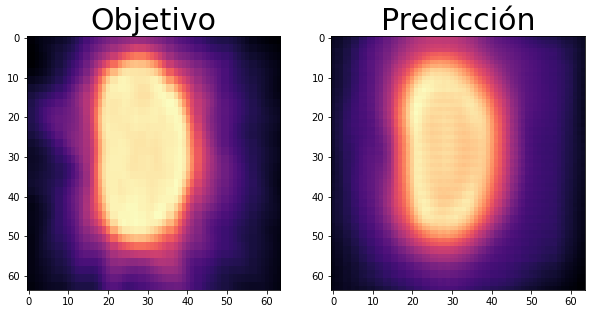

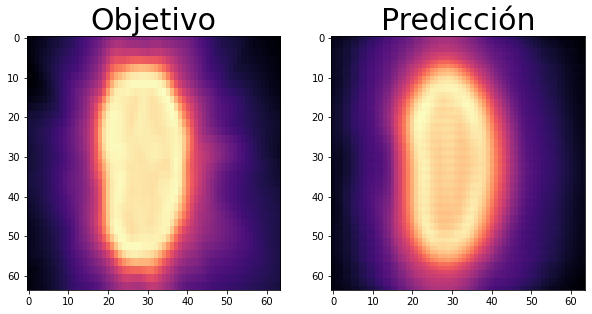

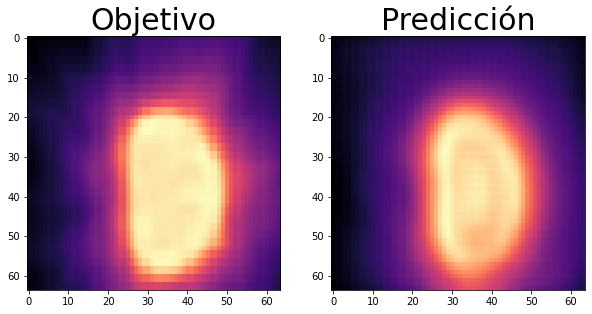

In [37]:
#10 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 100 épocas con BCEDiceLoss

In [40]:
hist, met = fit(epochs=100, loss_fn = BCEDiceLoss())


Epoch 1/100


test_loss 0.65340 iou 0.091 dice 0.167: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.18it/s]


Valid loss improved from inf to 0.6534. Saving checkpoint: file/checkpoint.pth

Epoch 2/100


test_loss 0.65169 iou 0.077 dice 0.143: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.45it/s]


Valid loss improved from 0.6534 to 0.6517. Saving checkpoint: file/checkpoint.pth

Epoch 3/100


test_loss 0.65092 iou 0.081 dice 0.150: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.00it/s]


Valid loss improved from 0.6517 to 0.6509. Saving checkpoint: file/checkpoint.pth

Epoch 4/100


test_loss 0.65133 iou 0.087 dice 0.161: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.31it/s]



Epoch 5/100


test_loss 0.65143 iou 0.098 dice 0.178: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]



Epoch 6/100


test_loss 0.65177 iou 0.090 dice 0.165: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]



Epoch 7/100


test_loss 0.65185 iou 0.112 dice 0.202: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.46it/s]



Epoch 8/100


test_loss 0.65090 iou 0.092 dice 0.168: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Valid loss improved from 0.6509 to 0.6509. Saving checkpoint: file/checkpoint.pth

Epoch 9/100


test_loss 0.65096 iou 0.080 dice 0.149: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.27it/s]



Epoch 10/100


test_loss 0.65065 iou 0.090 dice 0.164: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.33it/s]


Valid loss improved from 0.6509 to 0.6506. Saving checkpoint: file/checkpoint.pth

Epoch 11/100


test_loss 0.65065 iou 0.088 dice 0.161: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.89it/s]


Valid loss improved from 0.6506 to 0.6506. Saving checkpoint: file/checkpoint.pth

Epoch 12/100


test_loss 0.65048 iou 0.090 dice 0.166: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.86it/s]


Valid loss improved from 0.6506 to 0.6505. Saving checkpoint: file/checkpoint.pth

Epoch 13/100


test_loss 0.65041 iou 0.081 dice 0.150: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.98it/s]


Valid loss improved from 0.6505 to 0.6504. Saving checkpoint: file/checkpoint.pth

Epoch 14/100


test_loss 0.65048 iou 0.085 dice 0.158: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.75it/s]



Epoch 15/100


test_loss 0.65050 iou 0.084 dice 0.155: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]



Epoch 16/100


test_loss 0.65057 iou 0.090 dice 0.165: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.51it/s]



Epoch 17/100


test_loss 0.65052 iou 0.077 dice 0.143: 100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.90it/s]



Epoch 18/100


test_loss 0.65104 iou 0.083 dice 0.153: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.94it/s]



Epoch 19/100


test_loss 0.65036 iou 0.083 dice 0.153: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.70it/s]


Valid loss improved from 0.6504 to 0.6504. Saving checkpoint: file/checkpoint.pth

Epoch 20/100


test_loss 0.65053 iou 0.086 dice 0.159: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.89it/s]



Epoch 21/100


test_loss 0.65069 iou 0.080 dice 0.149: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.48it/s]



Epoch 22/100


test_loss 0.65109 iou 0.077 dice 0.142: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.72it/s]



Epoch 23/100


test_loss 0.65056 iou 0.077 dice 0.142: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.69it/s]



Epoch 24/100


test_loss 0.65046 iou 0.081 dice 0.150: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.77it/s]



Epoch 25/100


test_loss 0.65080 iou 0.082 dice 0.151: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.75it/s]



Epoch 26/100


test_loss 0.65062 iou 0.075 dice 0.139: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.14it/s]



Epoch 27/100


test_loss 0.65035 iou 0.083 dice 0.153: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.87it/s]


Valid loss improved from 0.6504 to 0.6504. Saving checkpoint: file/checkpoint.pth

Epoch 28/100


test_loss 0.65084 iou 0.088 dice 0.162: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.12it/s]



Epoch 29/100


test_loss 0.65052 iou 0.082 dice 0.151: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.63it/s]



Epoch 30/100


test_loss 0.65040 iou 0.082 dice 0.152: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.18it/s]



Epoch 31/100


test_loss 0.65039 iou 0.082 dice 0.151: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.09it/s]



Epoch 32/100


test_loss 0.65056 iou 0.084 dice 0.155: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.37it/s]



Epoch 33/100


test_loss 0.65050 iou 0.084 dice 0.156: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.55it/s]



Epoch 34/100


test_loss 0.65033 iou 0.080 dice 0.148: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.66it/s]


Valid loss improved from 0.6504 to 0.6503. Saving checkpoint: file/checkpoint.pth

Epoch 35/100


test_loss 0.65044 iou 0.080 dice 0.148: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.83it/s]



Epoch 36/100


test_loss 0.65068 iou 0.086 dice 0.159: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]



Epoch 37/100


test_loss 0.65066 iou 0.076 dice 0.142: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]



Epoch 38/100


test_loss 0.65078 iou 0.089 dice 0.164: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.17it/s]



Epoch 39/100


test_loss 0.65039 iou 0.080 dice 0.149: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.93it/s]



Epoch 40/100


test_loss 0.65087 iou 0.080 dice 0.148: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.42it/s]



Epoch 41/100


test_loss 0.65036 iou 0.075 dice 0.139: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]



Epoch 42/100


test_loss 0.65067 iou 0.085 dice 0.157: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.63it/s]



Epoch 43/100


test_loss 0.65055 iou 0.083 dice 0.154: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.82it/s]



Epoch 44/100


test_loss 0.65047 iou 0.083 dice 0.153: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.84it/s]



Epoch 45/100


test_loss 0.65033 iou 0.083 dice 0.153: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Valid loss improved from 0.6503 to 0.6503. Saving checkpoint: file/checkpoint.pth

Epoch 46/100


test_loss 0.65059 iou 0.079 dice 0.146: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]



Epoch 47/100


test_loss 0.65043 iou 0.089 dice 0.164: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.68it/s]



Epoch 48/100


test_loss 0.65031 iou 0.079 dice 0.147: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Valid loss improved from 0.6503 to 0.6503. Saving checkpoint: file/checkpoint.pth

Epoch 49/100


test_loss 0.65044 iou 0.084 dice 0.156: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.36it/s]



Epoch 50/100


test_loss 0.65066 iou 0.083 dice 0.153: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.44it/s]



Epoch 51/100


test_loss 0.65075 iou 0.080 dice 0.148: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]



Epoch 52/100


test_loss 0.65046 iou 0.086 dice 0.158: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.78it/s]



Epoch 53/100


test_loss 0.65067 iou 0.079 dice 0.146: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.05it/s]



Epoch 54/100


test_loss 0.65050 iou 0.083 dice 0.154: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.45it/s]



Epoch 55/100


test_loss 0.65040 iou 0.076 dice 0.142: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.57it/s]



Epoch 56/100


test_loss 0.65062 iou 0.081 dice 0.150: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]



Epoch 57/100


test_loss 0.65036 iou 0.076 dice 0.141: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.12it/s]



Epoch 58/100


test_loss 0.65070 iou 0.087 dice 0.159: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.51it/s]



Epoch 59/100


test_loss 0.65085 iou 0.082 dice 0.152: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]



Epoch 60/100


test_loss 0.65097 iou 0.082 dice 0.152: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.22it/s]



Epoch 61/100


test_loss 0.65074 iou 0.088 dice 0.162: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]



Epoch 62/100


test_loss 0.65049 iou 0.078 dice 0.145: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.62it/s]



Epoch 63/100


test_loss 0.65072 iou 0.090 dice 0.165: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]



Epoch 64/100


test_loss 0.65056 iou 0.085 dice 0.156: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.40it/s]



Epoch 65/100


test_loss 0.65063 iou 0.080 dice 0.148: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.72it/s]



Epoch 66/100


test_loss 0.65069 iou 0.086 dice 0.158: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.37it/s]



Epoch 67/100


test_loss 0.65081 iou 0.071 dice 0.132: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.13it/s]



Epoch 68/100


test_loss 0.65072 iou 0.083 dice 0.153: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.44it/s]



Epoch 69/100


test_loss 0.65056 iou 0.080 dice 0.149: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.03it/s]



Epoch 70/100


test_loss 0.65028 iou 0.081 dice 0.150: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.52it/s]


Valid loss improved from 0.6503 to 0.6503. Saving checkpoint: file/checkpoint.pth

Epoch 71/100


test_loss 0.65054 iou 0.081 dice 0.150: 100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]



Epoch 72/100


test_loss 0.65073 iou 0.086 dice 0.159: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.64it/s]



Epoch 73/100


test_loss 0.65026 iou 0.076 dice 0.141: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.02it/s]


Valid loss improved from 0.6503 to 0.6503. Saving checkpoint: file/checkpoint.pth

Epoch 74/100


test_loss 0.65040 iou 0.086 dice 0.159: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.65it/s]



Epoch 75/100


test_loss 0.65057 iou 0.083 dice 0.154: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.01it/s]



Epoch 76/100


test_loss 0.65045 iou 0.082 dice 0.151: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.80it/s]



Epoch 77/100


test_loss 0.65073 iou 0.082 dice 0.152: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.18it/s]



Epoch 78/100


test_loss 0.65081 iou 0.083 dice 0.153: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.26it/s]



Epoch 79/100


test_loss 0.65061 iou 0.076 dice 0.141: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.58it/s]



Epoch 80/100


test_loss 0.65051 iou 0.074 dice 0.138: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.17it/s]



Epoch 81/100


test_loss 0.65039 iou 0.073 dice 0.135: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.30it/s]



Epoch 82/100


test_loss 0.65041 iou 0.077 dice 0.143: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.87it/s]



Epoch 83/100


test_loss 0.65077 iou 0.087 dice 0.160: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.59it/s]



Epoch 84/100


test_loss 0.65044 iou 0.079 dice 0.147: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.01it/s]



Epoch 85/100


test_loss 0.65082 iou 0.092 dice 0.168: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.97it/s]



Epoch 86/100


test_loss 0.65059 iou 0.081 dice 0.149: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  6.00it/s]



Epoch 87/100


test_loss 0.65068 iou 0.086 dice 0.158: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.99it/s]



Epoch 88/100


test_loss 0.65060 iou 0.081 dice 0.150: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.16it/s]



Epoch 89/100


test_loss 0.65087 iou 0.082 dice 0.151: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.81it/s]



Epoch 90/100


test_loss 0.65135 iou 0.090 dice 0.165: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.92it/s]



Epoch 91/100


test_loss 0.65038 iou 0.079 dice 0.147: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.36it/s]



Epoch 92/100


test_loss 0.65036 iou 0.081 dice 0.149: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.36it/s]



Epoch 93/100


test_loss 0.65042 iou 0.084 dice 0.155: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]



Epoch 94/100


test_loss 0.65056 iou 0.085 dice 0.157: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.00it/s]



Epoch 95/100


test_loss 0.65042 iou 0.079 dice 0.147: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.72it/s]



Epoch 96/100


test_loss 0.65045 iou 0.078 dice 0.146: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.66it/s]



Epoch 97/100


test_loss 0.65110 iou 0.091 dice 0.167: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.78it/s]



Epoch 98/100


test_loss 0.65051 iou 0.084 dice 0.155: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.82it/s]



Epoch 99/100


test_loss 0.65044 iou 0.085 dice 0.156: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.73it/s]



Epoch 100/100


test_loss 0.65045 iou 0.077 dice 0.143: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.67it/s]


 Entrenamiento de 100 epocas finalizado en 53m 14s



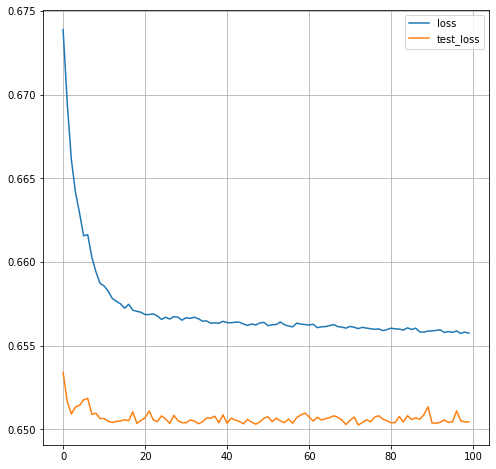

In [41]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

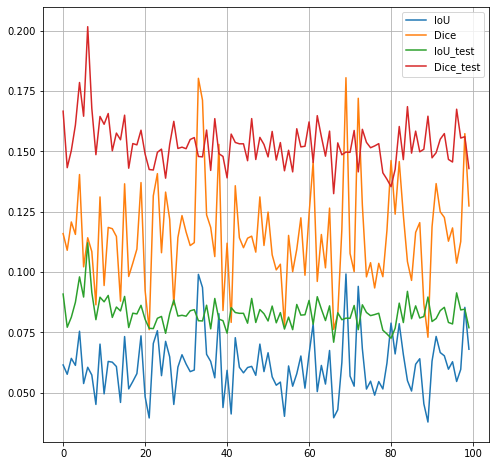

In [42]:
#100 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

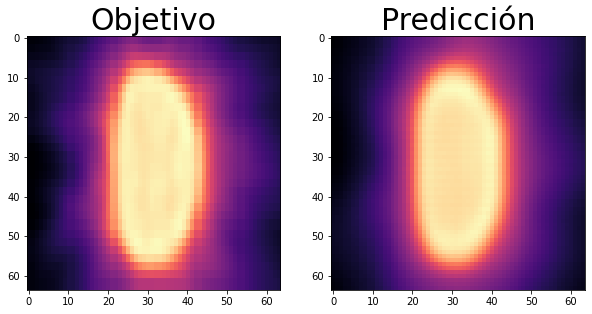

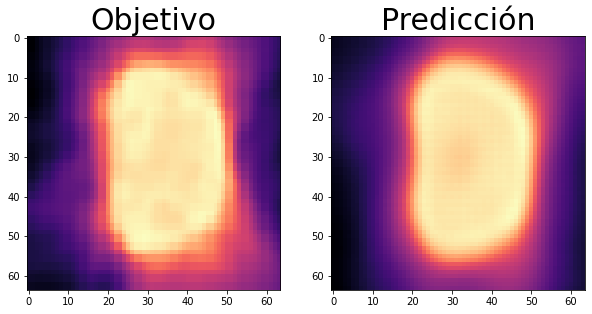

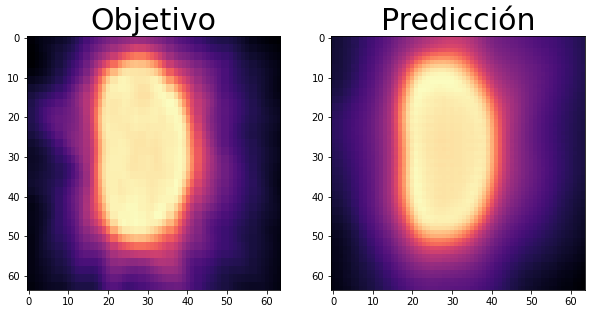

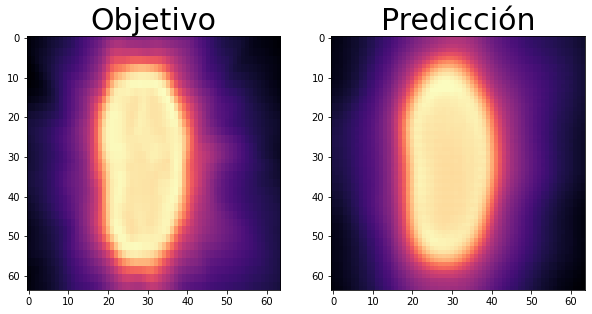

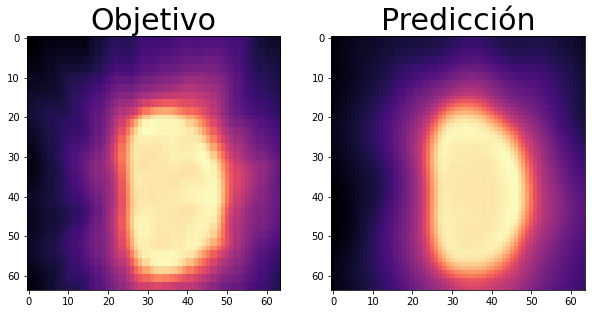

In [43]:
#100 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()